In [28]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

from sklearn.externals import joblib

dataset_dir = './CSV_files/'   # Path to load raw Audio Set data
resampling_path = './SMOTE_data/'   # Path to load oversampled Audio Set training data
test_data_dir = './'   # Path to load real-world data for dedicated study
save_model_dir = './well_trained_classifiers_SMOTE/'   # Path to save/load CNN model
classes = ['Bathing',
          'Flushing toilet',
          'Brushing teeth',
          'Shavering',
          'Frying food',
          'Chopping food',
          'Using microwave oven',
          'Boiling water', 
          'Squeezing juice',
          'Watching TV', 
          'Playing Music', 
          'Vacuum cleaning',  
          'Washing',
          'Chatting', 
          'Strolling']

using_raw_data = False   # True: using raw embeddings; False: using oversampled embeddings

In [2]:
def uint8_to_float32(x):   # Standardrization
    return (np.float32(x) - 128.) / 128.

In [3]:
'''Codes to load raw embeddings'''

if using_raw_data == True:
    training_data = [pd.DataFrame() for i in range(len(classes))]
    training_labels = [] 
    training_data_fit = pd.DataFrame()
    
    '''Input raw embeddings'''  
    training_sets = [x for x in os.listdir(dataset_dir) if x.endswith('.csv')]
    print (training_sets)
    for file_name in training_sets:
        class_index = int(file_name.split('_')[-1].strip('.csv'))
        temp_data = pd.read_csv(dataset_dir + file_name, header=None)
        # 11 single classes, filter 'lawn mower' (csv index 12)
        if class_index <= 11:   
            training_data[class_index] = training_data[class_index].append(temp_data)
        # Washing
        elif class_index == 13 or class_index == 14:   
            training_data[12] = training_data[12].append(temp_data)
        # Speaking
        elif class_index == 15 or class_index == 16:   
            training_data[13] = training_data[13].append(temp_data)
        # Step walking
        elif class_index == 17 or class_index == 18:   
            training_data[14] = training_data[14].append(temp_data)
    for i in range(len(training_data)):
        training_data[i] = pd.DataFrame(training_data[i])
        print('# of %s' % classes[i] + ' embeddings: %d' % training_data[i].shape[0], '\n')
        training_data_fit = training_data_fit.append(training_data[i])
        
    training_data_fit = training_data_fit.values   # Training data to fit the classifiers
    print('Total training set size:', training_data_fit.shape, '\n')
    
    '''Set training labels'''
    for i in range(len(training_data)):
        label_count = 0
        for row in range(training_data[i].shape[0]):   # Set training labels for each class
            training_labels.append(i)
            label_count += 1
        print('# of %s' % classes[i] + ' labels: %d' % label_count)
    training_labels = np.asarray(training_labels)
    training_labels = np.ndarray.flatten(training_labels)   # Training labels to fit the classifiers
    print('Total training label size:', training_labels.shape, '\n')

['unbal_10.csv', 'bal+eval_8.csv', 'bal+eval_0.csv', 'bal+eval_10.csv', 'bal+eval_2.csv', 'unbal_9.csv', 'bal+eval_14.csv', 'unbal_3.csv', 'bal+eval_11.csv', 'unbal_7.csv', 'unbal_1.csv', 'unbal_4.csv', 'bal+eval_18.csv', 'unbal_15.csv', 'unbal_5.csv', 'unbal_2.csv', 'unbal_14.csv', 'unbal_17.csv', 'unbal_6.csv', 'unbal_18.csv', 'unbal_16.csv', 'unbal_12.csv', 'bal+eval_5.csv', 'bal+eval_4.csv', 'unbal_8.csv', 'bal+eval_1.csv', 'bal+eval_13.csv', 'bal+eval_16.csv', 'bal+eval_12.csv', 'bal+eval_3.csv', 'bal+eval_7.csv', 'bal+eval_15.csv', 'unbal_0.csv', 'bal+eval_6.csv', 'bal+eval_9.csv', 'bal+eval_17.csv', 'unbal_13.csv', 'unbal_11.csv']
# of Bathing embeddings: 14270 

# of Flushing toilet embeddings: 22190 

# of Brushing teeth embeddings: 1230 

# of Shavering embeddings: 8570 

# of Frying food embeddings: 15820 

# of Chopping food embeddings: 2060 

# of Using microwave oven embeddings: 8180 

# of Boiling water embeddings: 4440 

# of Squeezing juice embeddings: 12600 

# of Wat

In [29]:
'''Codes to load oversampled embeddings'''  

if using_raw_data == False:
    training_data_fit = pd.read_csv(resampling_path + 'SMOTE_data_15classes.csv',
                                    header=None).values   # Training set
    training_labels = pd.read_csv(resampling_path + 'SMOTE_labels_15classes.csv',
                                    header=None).values
    print ('training_data_fit shape:', training_data_fit.shape)
    print ('training_labels shape:', training_labels.shape)

training_data_fit shape: (2613300, 128)
training_labels shape: (2613300, 1)


In [30]:
'''Train validation split'''


training_data_fit, eval_data, training_labels, eval_labels = train_test_split(training_data_fit, training_labels, 
                                                                              test_size=0.1,
                                                                             random_state=0)
print ('training_data_fit shape:', training_data_fit.shape)
print ('training_labels shape:', training_labels.shape)
print ('eval_data_fit shape:', eval_data.shape)
print ('eval_labels shape:', eval_labels.shape)

training_data_fit shape: (2351970, 128)
training_labels shape: (2351970, 1)
eval_data_fit shape: (261330, 128)
eval_labels shape: (261330, 1)


In [6]:
''' Load dedicated study data '''

file_test = pd.read_csv(test_data_dir + 'feasibility_overall_0726.csv',
                        header=None)   # Load evaluation set
test_data = file_test.values[:,0:128]
test_data = uint8_to_float32(test_data)
array_stack = test_data[0]   # Create an array to store the meaned test data

i = 0
while i < test_data.shape[0]-9:   # Average every 10 sec
    try:
        temp = test_data[i]
        temp = np.vstack((temp, test_data[i+1]))
        temp = np.vstack((temp, test_data[i+2]))
        temp = np.vstack((temp, test_data[i+3]))
        temp = np.vstack((temp, test_data[i+4]))
        temp = np.vstack((temp, test_data[i+5]))
        temp = np.vstack((temp, test_data[i+6]))
        temp = np.vstack((temp, test_data[i+7]))
        temp = np.vstack((temp, test_data[i+8]))
        temp = np.vstack((temp, test_data[i+9]))
        array_stack = np.vstack((array_stack, np.mean(temp, axis = 0)))
        i += 10
    except:
        print('Segment not able to be grouped by 10 seconds')
        pass
test_data_mean = array_stack[1:,:]   # Meaned test data to predict
print('test_data_mean.shape:', test_data_mean.shape, '\n')

test_data_mean.shape: (90, 128) 



In [7]:
'''Set dedicated study groud truth labels'''   
truthLabels = []   # Groundtruth for evaluation data

for i in range(len(classes)):
    test_label_count = 0
    for test_label_count in range(0, int(test_data_mean.shape[0] / len(classes))):
        truthLabels.append(i)
    continue
truthLabels = np.asarray(truthLabels)
truthLabels = np.ndarray.flatten(truthLabels)
print('TruthLabels shape:', truthLabels.shape, '\n')

TruthLabels shape: (90,) 



In [8]:
print(truthLabels[0])

0


In [31]:
'''Fit classifiers'''

classifiers = [LinearSVC(random_state=0), 
               SVC(kernel='sigmoid', random_state = 0),
               RandomForestClassifier(n_estimators=500, max_features ='auto', random_state = 0, n_jobs=-1),
               tree.DecisionTreeClassifier(),
               KNeighborsClassifier(n_neighbors=20)]

clf = classifiers[2]   # Select classifier
print('Selection is:', clf)
print('Start training...')
clf.fit(training_data_fit, training_labels) 
print('Training completes')


Selection is: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Start training...


/home/05563/dl33629/WORK/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


Training completes


In [32]:
'''Validation'''

prediction = []
prediction.append(clf.predict(eval_data))   
C = confusion_matrix(eval_labels, prediction[0])
acc = accuracy_score(eval_labels, prediction[0])
F1 = f1_score(eval_labels, prediction[0], average='weighted')
precision = precision_score(eval_labels, prediction[0], average='weighted')
recall = recall_score(eval_labels, prediction[0], average='weighted')

print('acc:', acc, '\n', 'F1:', F1, '\n', 'precision:', precision, '\n', 'recall:', recall)

acc: 0.9641870432020817 
 F1: 0.9642268905578348 
 precision: 0.9646983296562046 
 recall: 0.9641870432020817


In [34]:
'''Save classifier'''

para = clf.get_params()  
filename =  str(clf).split('(')[0] + '_n_estimators_' + str(para['n_estimators']) \
            + '_max_features_' + str(para['max_features']) \
            + '_random_state_' + str(para['random_state']) \
            +'_15classes'
joblib.dump(clf, save_model_dir + filename)
print('Model saved, file name:', filename)

Model saved, file name: RandomForestClassifier_n_estimators_500_max_features_auto_random_state_0_15classes


In [35]:
'''Load classifier'''

clf = joblib.load(save_model_dir + filename)
print('Loaded clf:', filename)

Loaded clf: RandomForestClassifier_n_estimators_500_max_features_auto_random_state_0_15classes


Prediction: [ 1  1 11  1  1  1  9 11  3  3]
acc: 0.45555555555555555 
 F1: 0.3709660274366156 
 precision: 0.34866522366522373 
 recall: 0.45555555555555555
Normalized confusion matrix
[[0.         0.83333333 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.16666667
  0.         0.         0.        ]
 [0.         0.16666667 0.         0.33333333 0.         0.
  0.         0.         0.16666667 0.16666667 0.         0.16666667
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         1.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.16666667 0.         0.
  0.         0.         0.16666667 0.         0.         0.66666667
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.66666667 0.
  0.         0.         0.         0.         0.         0.
  0.33333333 0.         0.        ]
 [0.       

/home/05563/dl33629/WORK/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/05563/dl33629/WORK/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


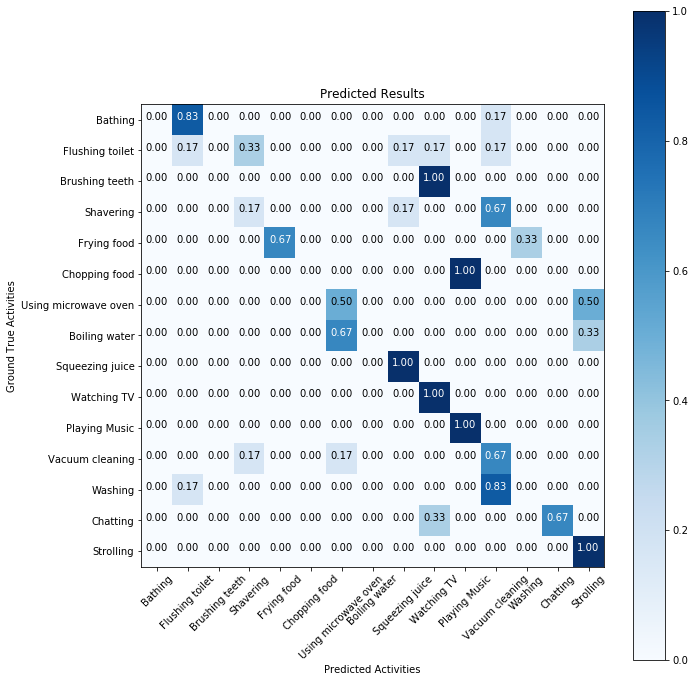

In [36]:
'''Prediction and results analysis'''

import itertools
import matplotlib.pyplot as plt

"""
Function to print and plot the confusion matrix.
Normalization can be applied by setting `normalize=True`.
Template adopted from on line!
"""
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Ground True Activities')
    plt.xlabel('Predicted Activities')


'''Predictions'''
prediction = []
prediction.append(clf.predict(test_data_mean))   #from test_data_mean[1:]
print('Prediction:', prediction[0][:10])
C = confusion_matrix(truthLabels, prediction[0])
acc = accuracy_score(truthLabels, prediction[0])
F1 = f1_score(truthLabels, prediction[0], average='weighted')
precision = precision_score(truthLabels, prediction[0], average='weighted')
recall = recall_score(truthLabels, prediction[0], average='weighted')


print('acc:', acc, '\n', 'F1:', F1, '\n', 'precision:', precision, '\n', 'recall:', recall)


'''Plot confusion matrix'''
plt.figure(num=1, figsize=(10,10))
display_names = classes
plot_confusion_matrix(C, classes=display_names, normalize=True,
                      title='Predicted Results')
plt.show()